# Social Cluster Detection and Visualization with Doc2Vec
### Simon Schneider, 2017

### Overview

Word2Vec treats an individual word as a unique token, which means there's nothing
stopping us from applying the algorithm to non-NLP problems. The underlying task is to predict
occurence of a token given its context, so any problem domain in which the context
can be encoded in a sequence of tokens is a candidate for throwing Word2Vec at.

Word2Vec can learn meaningful vector representations of words essentially
because analogous words tend to occur in analogous contexts. Words that occur
in the same contexts tend to have proximal representative vectors, and differences 
between vectors can carry semantic meaning. These embedded vectors are well suited
for machine learning tasks such as clustering, classification, or similarity 
detection.

A modication to Word2Vec, dubbed Doc2Vec, learns vector representations of 
whole documents, simply by appending a document-specific tag to the context windows of
the prediction task [1]. One (mathematical) way to think about this: a
document's vector defines a bias over the word vectors that increases the
probability of predicting that document's words given their context windows.
We're also free to stack such biases additively, by attaching multiple
(and non-document-specific) tags to a document.

Let's see if Word2Vec can identify major clusters in a social network. We have good reason to be
optimistic: both the problem and the algorithm can be recast in terms of factoring a co-occurance matrix.
Let's also see if we can display the network in an easy-for-human-comprehension kind of way.

In [1]:
import logging
from networkx import Graph
from numpy.random import randint

from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pandas import DataFrame

import matplotlib.pyplot as plt
from matplotlib import collections as mc
from pylab import rcParams, subplots

rcParams['figure.figsize'] = (25, 15)

from fastcluster import linkage
from scipy.cluster.hierarchy import cophenet, fcluster, dendrogram
from scipy.spatial.distance import pdist

from sklearn.cluster import KMeans

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO,
                    filename='../log/facebook.log')

### Munge

One of SNAP's datasets includes a small text file containing the friendships between 4.3K anonymized 
facebook users. There are 88K friendships, or for a mean of about 20 friendships per user. This one's
easy: let's read the file, build the network graph, and store it in memory.

Word2Vec expects "sentences", so what do those look like in our problem? Let's try random walks of the social
graph, with user as "words". After minimal experimentation, the lengths of these random walks was set to 25.
The size of the "context window" has a clear interpretation here: it places an upper bound on how
many degrees of seperation we're using to define a user's social context.

There's another cool trick we can use: use Doc2Vec to learn both a word and a document vector for each user.
The words are the users along the randon walk, and the document tag is the user the walk started from.
The word vectors will be sensitive only to friendships within users' social contexts, but the document
vectors will be especially sensitive to people in users' extended social circles. As we'll see, this
long-range sensitivity leads to good coarse-grained cluster detection, at the expense of obscuring
some of the details of the network.

4.3K is a much smaller vocabulary than Word2Vec usually sees. To compensate, use small
dimensionality for the embedding vector spaces, and concatenate two different embeddings:
those with degrees of speration < 3 and < 7 in users' social contexts.

In [2]:
SOURCE_PATH = '../datasets/facebook_combined.txt'

nodes = set([])
pairs = []

with open(SOURCE_PATH, 'r') as fin:
    for line in fin:
        xs = [x.strip() for x in line.split(' ')]
        nodes.update(xs)
        pairs += [xs]

# make graph, add nodes  
graph = Graph()
nodes = list(nodes)
graph.add_nodes_from(nodes)

# add edges (symmetrically)
graph.add_edges_from(pairs)
graph.add_edges_from([(y,x) for x,y in pairs])

In [3]:
def random_neighbor(x, graph=graph):
    ys = list(graph[x].keys())
    return ys[randint(low=0, high=len(ys))]


def random_chain(length, x0=None, graph=graph, nodes=nodes):
    if x0 is None:
        x0 = nodes[randint(low=0, high=len(nodes))]
    x = x0
    ys = [x0]
    for _ in range(length - 1):
        y = random_neighbor(x, graph)
        ys += [y]
        x = y
    return ys


class GraphRandomWalk(object):
    def __init__(self, n_chains, chain_len):
        self.n_chains = n_chains
        self.chain_len = chain_len
    def __iter__(self):
        for _ in range(self.n_chains - len(nodes)):
            # generate a chain
            chain = random_chain(self.chain_len)
            yield LabeledSentence(words=chain, tags=[chain[0]])
        for node in nodes:
            chain = random_chain(self.chain_len, node)
            yield LabeledSentence(words=chain, tags=[chain[0]])


def train_model(size, window):
    return Doc2Vec(GraphRandomWalk(80000, 25),
                   workers=5,
                   size=size, window=window, negative=20,
                   iter=10, alpha=0.1, min_count=1, sample=0)


# two models, different degrees of seperation
model_far = train_model(80, 6)
model_near = train_model(80, 2)

sum(pca.explained_variance_ratio_) ==  0.457126812968
tsne.kl_divergence_ ==  1.4242852926254272


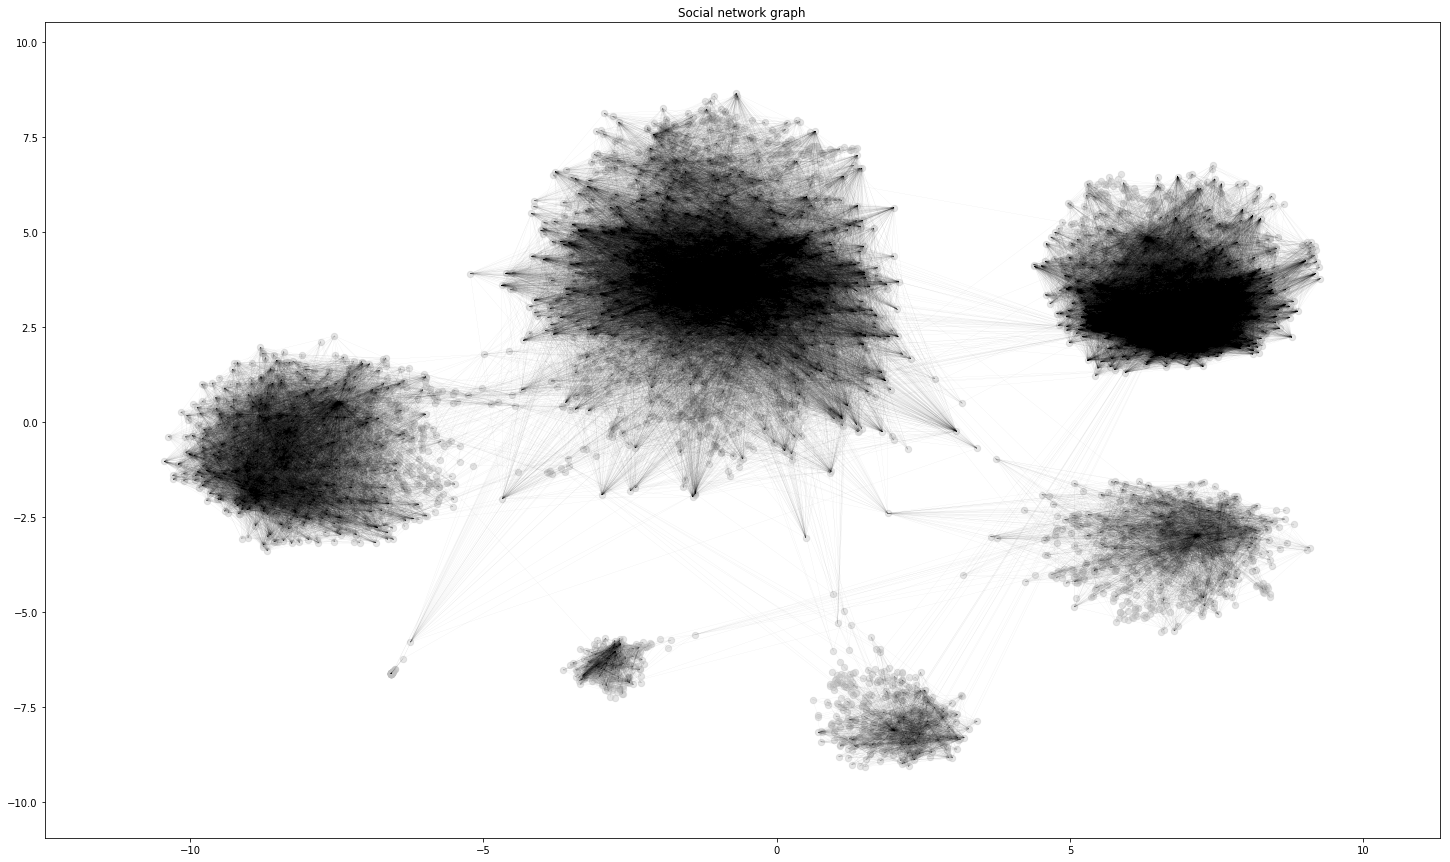

In [4]:
"""plot users and friendships in t-SNE space
using mostly the doc vectors
"""

# PCA, t-SNE 

users = list(model_near.wv.vocab.keys())
X1 = np.hstack([1.0 * model_far.docvecs[users],
               1.0 * model_near.docvecs[users],
               0.33 * model_near[users]])

pca = PCA(50)
tsne = TSNE(metric='cosine', perplexity=50, verbose=0)

Y1 = pca.fit_transform(X1)
Z1 = tsne.fit_transform(Y1)

print('sum(pca.explained_variance_ratio_) == ', np.sum(pca.explained_variance_ratio_))
print('tsne.kl_divergence_ == ', tsne.kl_divergence_)

# map from user to x,y
dim_user1 = (DataFrame({'user': users,
                           'x': [Z1[:, 0][users.index(u)] for u in users],
                           'y': [Z1[:, 1][users.index(u)] for u in users]})
             .set_index('user'))


# friendships and their users' x,y's
dim_friendship1 = (DataFrame({'user_1': [a for a,_ in pairs],
                              'user_2': [b for _,b in pairs]})
                   .join(dim_user1, on='user_1')
                   .join(dim_user1, on='user_2', rsuffix='2'))

def make_line(row):
    return [(row.x, row.y), (row.x2, row.y2)]

lines1 = list(dim_friendship1.apply(make_line, 1))

lc = mc.LineCollection(lines1, linewidths=0.05, color = np.array([0, 0, 0, 0.4]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z1[:, 0], Z1[:, 1], s = 40, c = np.array([0.75, 0.75, 0.75, 0.4]))
plt.title('Social network graph')
plt.show()

### Discussion

I think this example is important for a few reasons. First, it's a dataset with < 100K rows and ~4.3K
distinct tokens. Although generating random walks through the network is a cool sampling trick, the
training data is still less than a million examples -- this isn't big data or anything. But the structure
of the problem is a good match for what Word2Vec does (again: factoring a symmetric measure of co-occurance),
and I was able to get a good result quickly.

Second, it illustrates how Doc2Vec trains word vectors and document vectors. Recall that word vectors only
get trained on context windows that contain that word, whereas document vectors get trained on every context
window in every document with a matching tag. Here, the document tags are who the random walks started at, which
means that the document vectors encode more information about who knows who *outside of* a user's immediate
friend group than the word vectors do. Two users will have proximal document vectors if they "run in similar crowds",
largely irrespective of whether they have any mutual friends. In contrast, the word vectors for two users will be
closer if they have more friends in common.

And third, it's a great opportunity to make some eye candy. The information in these embedded vectors can be rendered
visually with t-SNE diagrams [2], on which the network's social graph is plotted. The first diagram was made mostly from
the document vectors, with small contribution from the short-range word vectors to provide cleaner seperation between
the clusters. Six large clusters clearly turn up, and hierarchical clustering or k-means captures them very well. The second
t-SNE diagram takes the concatenated long- and short-range word and document vectors as input, and the result
captures much more of the structure of individual clusters while retaining distinction and not getting too noisy.

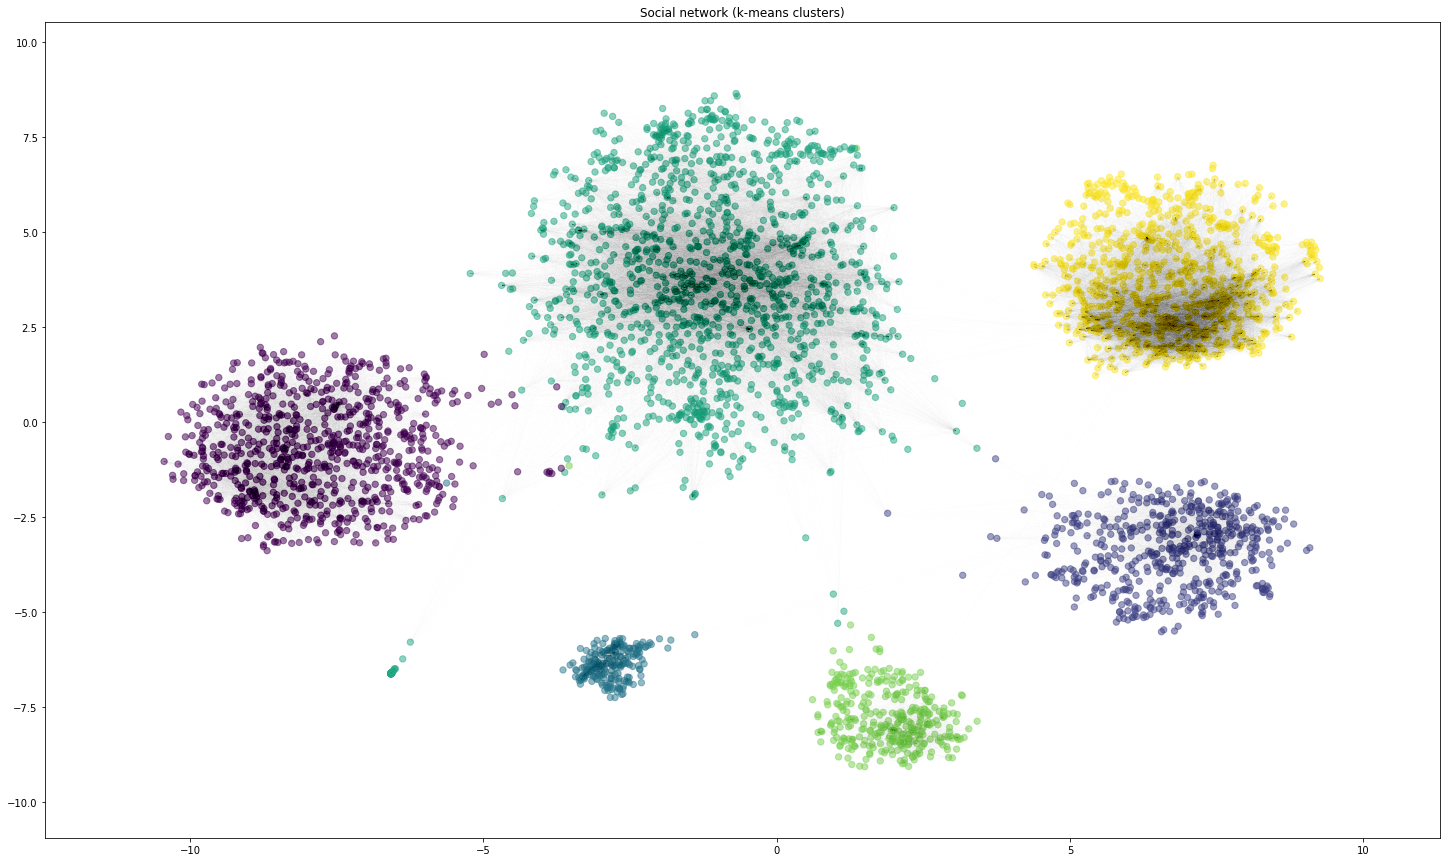

In [5]:
"""k-means clustering"""

C_kmeans = KMeans(6).fit_predict(X1)

lc = mc.LineCollection(lines1, linewidths=0.01, color = np.array([0, 0, 0, 0.2]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z1[:, 0], Z1[:, 1], s=40, c=C_kmeans, alpha=0.5)
plt.title('Social network (k-means clusters)')
plt.show()

0.618593374145


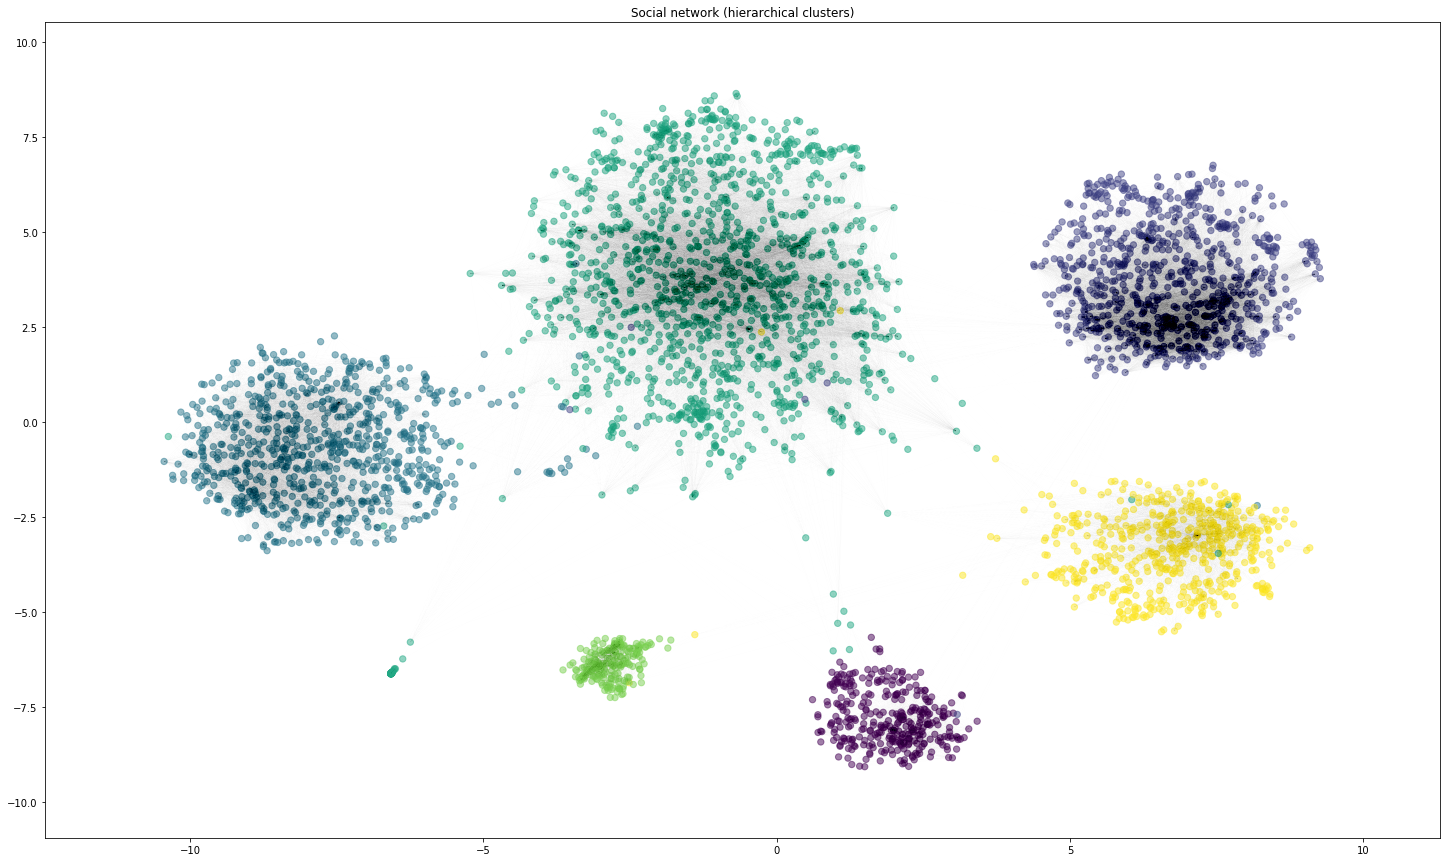

In [6]:
"""hierarchical clustering"""

W = linkage(X1, method='ward', metric='cosine')
C_hierarchy = fcluster(W, 6, criterion='maxclust')

c, coph_dists = cophenet(W, pdist(Z1))
print(c)

lc = mc.LineCollection(lines1, linewidths=0.01, color = np.array([0, 0, 0, 0.2]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z1[:, 0], Z1[:, 1], s=40, c=C_hierarchy, alpha=0.5)
plt.title('Social network (hierarchical clusters)')
plt.show()

In [7]:
def friendships_explained(C):
    """returns the fraction of friendships explained by the clusters"""
    dim_cluster = (DataFrame({'user': users,
                                 'c': list(C)})
                   .set_index('user'))

    whether_friendships_cluster = (dim_friendship1
     .join(dim_cluster, on='user_1')
     .join(dim_cluster, on='user_2', rsuffix='2')
     .apply(lambda row: row.c == row.c2, 1))

    return len(dim_friendship1[whether_friendships_cluster]) * 1.0 / len(dim_friendship1)


print("kmeans explains", friendships_explained(C_kmeans))
print("hierarchical explains", friendships_explained(C_hierarchy))

kmeans explains 0.9959652741573544
hierarchical explains 0.9871478115012353


sum(pca.explained_variance_ratio_) ==  0.474583838051
tsne.kl_divergence_ ==  1.0778417587280273


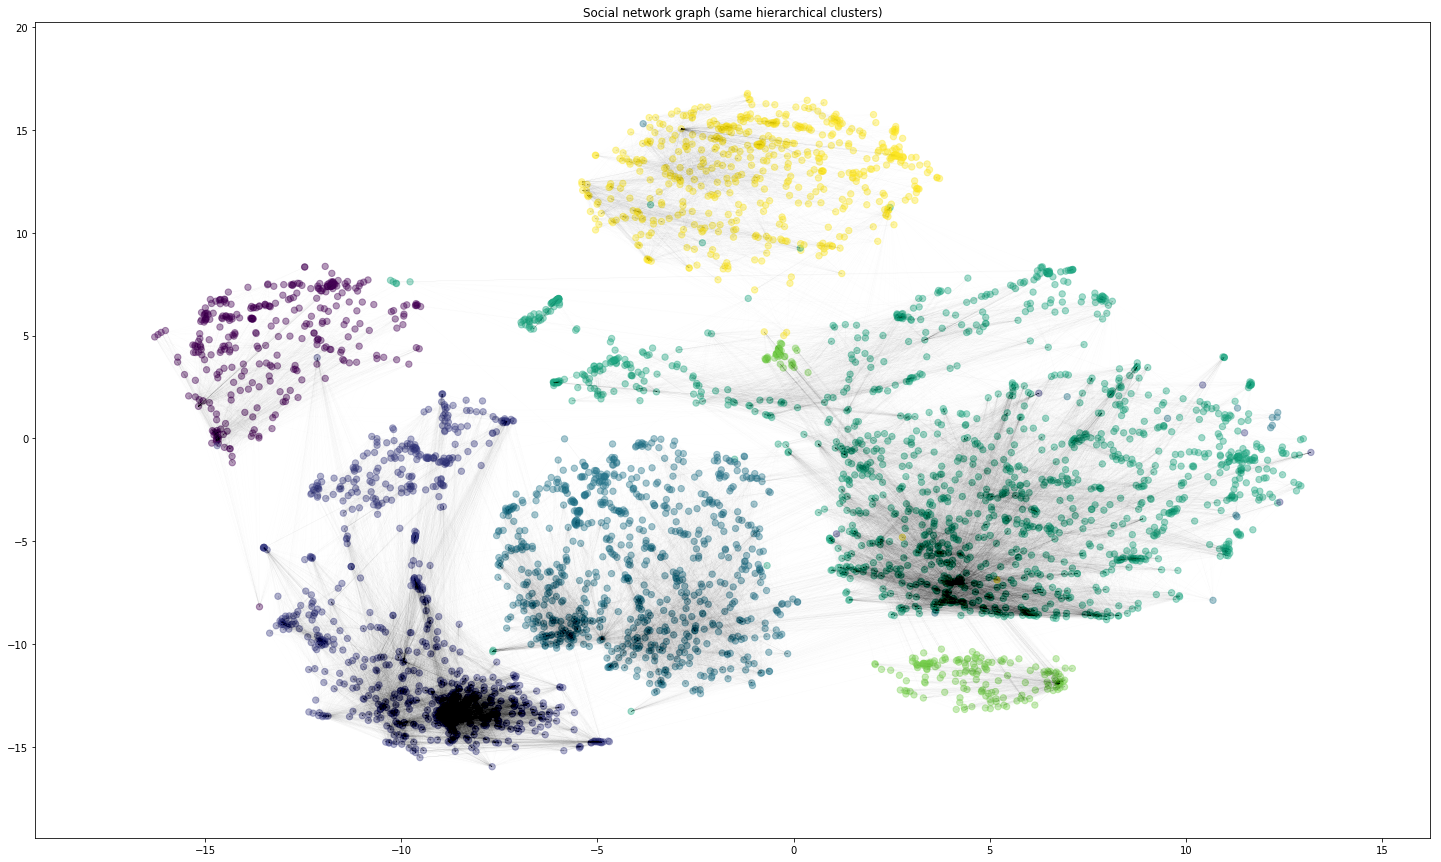

In [8]:
"""using word vectors and doc vectors"""

X2 = np.hstack([model_near.docvecs[users],
               model_far.docvecs[users],
               model_near[users],
               model_far[users]])

pca = PCA(50)
tsne = TSNE(metric='cosine', perplexity=50, verbose=0)

Y2 = pca.fit_transform(X2)
Z2 = tsne.fit_transform(Y2)

print('sum(pca.explained_variance_ratio_) == ', np.sum(pca.explained_variance_ratio_))
print('tsne.kl_divergence_ == ', tsne.kl_divergence_)

# map from key to coordinate
dim_user2 = (DataFrame({'user': users,
                           'x': Z2[:, 0],
                           'y': Z2[:, 1]})
             .set_index('user'))

# pairs (edges/friendships) and their coordinates
dim_friendships2 = (DataFrame({'user_1': [a for a,_ in pairs],
                               'user_2': [b for _,b in pairs]})
                    .join(dim_user2, on='user_1')
                    .join(dim_user2, on='user_2', rsuffix='2'))

def make_line(row):
    return [(row.x, row.y), (row.x2, row.y2)]

lines2 = list(dim_friendships2.apply(make_line, 1))

lc = mc.LineCollection(lines2, linewidths=0.01, color = np.array([0, 0, 0, 0.4]))
fig, ax = subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

plt.scatter(Z2[:, 0], Z2[:, 1], s = 40, c=C_hierarchy, alpha=0.4)
plt.title('Social network graph (same hierarchical clusters)')
plt.show()

### References

[1] QV Le and T Mikolov. Distributed Representations of Sentences and Documents. 2014

[2] L.J.P. van der Maaten, G.E. Hinton. Visualizing High-Dimensional Data Using
t-SNE. 2008